DISUSUN OLEH :

NIKO YASIN FEBRIAN (22.11.4563)

ANJAS SETIAWAN (22.11.4549)

DHIMAS ADITYA SAPUTRA (22.11.4604)

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize


drive.mount('/content/drive')

# Mengakses file yang ada di Google Drive (misal di folder 'My Drive')
file_path = '/content/drive/My Drive/Dataset Bdpa/bdpa data.csv'
df = pd.read_csv(file_path)
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         29.8      59.1    5.2  17.9  18.9   9.2  1.72   
1         28.3      75.6    2.3  12.2  30.8   9.7  1.64   
2         23.1      74.7   26.7  33.8  24.4  12.6  1.63   
3         27.1      39.1    6.1   6.3  13.5   5.3  1.15   
4         26.5      70.7    6.9  16.0  21.9   5.6  1.01   

   Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                            6.3                 319    Moderate  
1                            6.0                 611    Moderate  
2                            5.2                 619    Moderate  
3                           11.1                 551        Good  
4                           12.7                 303        Good  


In [7]:
print(df.dtypes)

Temperature                      float64
Humidity                         float64
PM2.5                            float64
PM10                             float64
NO2                              float64
SO2                              float64
CO                               float64
Proximity_to_Industrial_Areas    float64
Population_Density                 int64
Air Quality                       object
dtype: object


In [8]:
# Mengganti atau merubah type data
df['Temperature'] = df['Temperature'].astype('int64')
df['Humidity'] = df['Humidity'].astype('int64')
df['PM2.5'] = df['PM2.5'].astype('int64')
df['PM10'] = df['PM10'].astype('int64')
df['NO2'] = df['NO2'].astype('int64')
df['SO2'] = df['SO2'].astype('int64')
df['CO'] = df['CO'].astype('int64')
df['Proximity_to_Industrial_Areas'] = df['Proximity_to_Industrial_Areas'].astype('int64')
df['Air Quality'] = df['Air Quality'].astype('string')

In [9]:
print(df.dtypes)

Temperature                               int64
Humidity                                  int64
PM2.5                                     int64
PM10                                      int64
NO2                                       int64
SO2                                       int64
CO                                        int64
Proximity_to_Industrial_Areas             int64
Population_Density                        int64
Air Quality                      string[python]
dtype: object


In [10]:
#Merubah nama label
df = df.rename(columns={
    'Temperature': 'Suhu',
    'Humidity': 'Kelembaban',
    'Proximity_to_Industrial_Areas': 'Kedekatan_dengan_Kawasan_Industri',
    'Population_Density': 'Kepadatan_Penduduk',
    'PM2.5': 'PM2_5'
})

print(df.columns)

Index(['Suhu', 'Kelembaban', 'PM2_5', 'PM10', 'NO2', 'SO2', 'CO',
       'Kedekatan_dengan_Kawasan_Industri', 'Kepadatan_Penduduk',
       'Air Quality'],
      dtype='object')


In [11]:
#Menampilkan missing value
print(df.isnull().sum())

Suhu                                 0
Kelembaban                           0
PM2_5                                0
PM10                                 0
NO2                                  0
SO2                                  0
CO                                   0
Kedekatan_dengan_Kawasan_Industri    0
Kepadatan_Penduduk                   0
Air Quality                          0
dtype: int64


In [12]:
# Menampilkan statistik deskriptif dari setiap kolom
print(df.describe())

             Suhu   Kelembaban        PM2_5         PM10          NO2  \
count  5000.00000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     29.58300    69.611200    19.692000    29.773400    25.964400   
std       6.73051    15.866518    24.550741    27.348924     8.896638   
min      13.00000    36.000000     0.000000     0.000000     7.000000   
25%      25.00000    58.000000     4.000000    12.000000    20.000000   
50%      29.00000    69.000000    12.000000    21.000000    25.000000   
75%      34.00000    80.000000    26.000000    38.000000    31.000000   
max      58.00000   128.000000   295.000000   315.000000    64.000000   

               SO2           CO  Kedekatan_dengan_Kawasan_Industri  \
count  5000.000000  5000.000000                        5000.000000   
mean      9.567200     1.011400                           7.995600   
std       6.747517     0.647575                           3.622845   
min      -6.000000     0.000000                           2.00

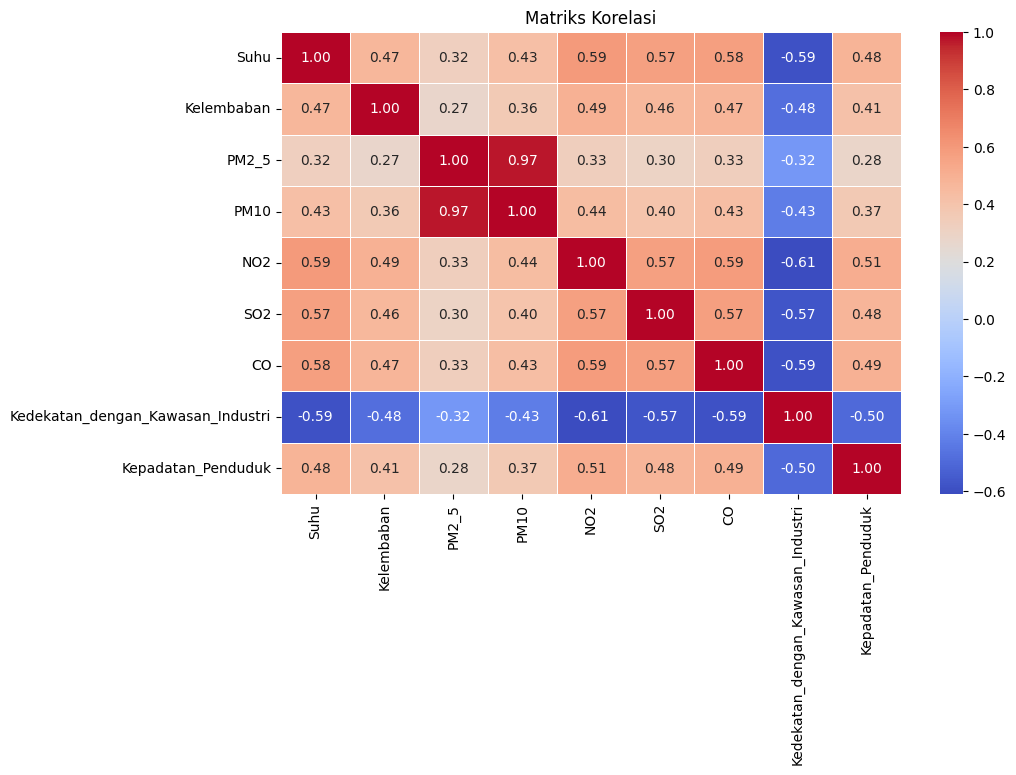

In [13]:
numerical_df = df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()

# Menampilkan matriks korelasi menggunakan heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriks Korelasi')
plt.show()


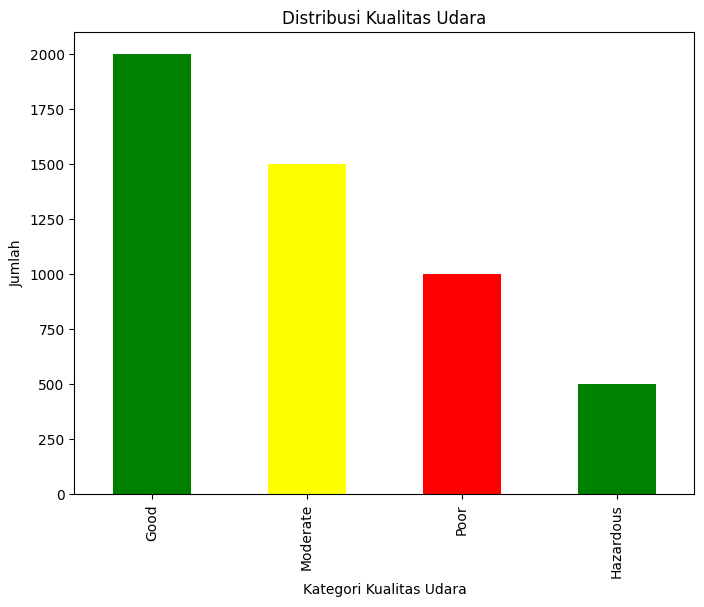

In [14]:
# Bar Chart
air_quality_counts = df['Air Quality'].value_counts()
air_quality_counts.plot(kind='bar', color=['green', 'yellow', 'red'], figsize=(8, 6))
plt.title('Distribusi Kualitas Udara')
plt.xlabel('Kategori Kualitas Udara')
plt.ylabel('Jumlah')
plt.show()

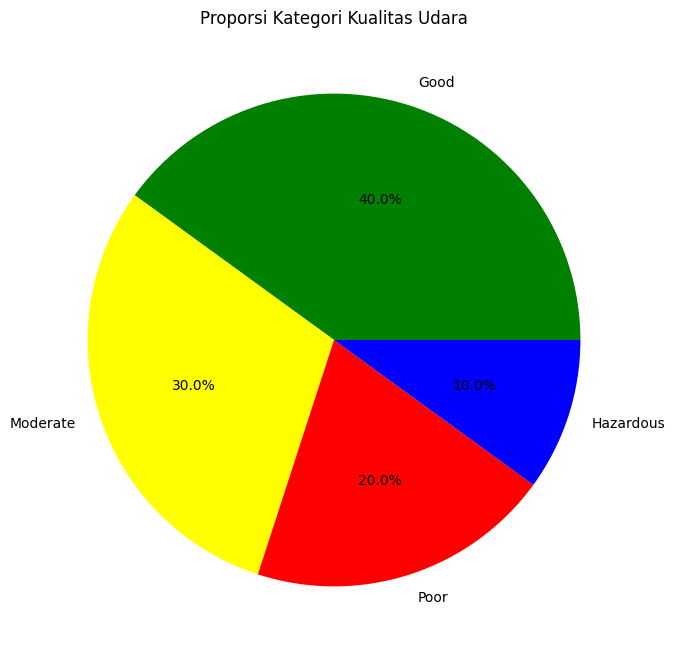

In [15]:
# Pie Chart
air_quality_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), colors=['green', 'yellow', 'red', 'blue'])
plt.title('Proporsi Kategori Kualitas Udara')
plt.ylabel('')
plt.show()

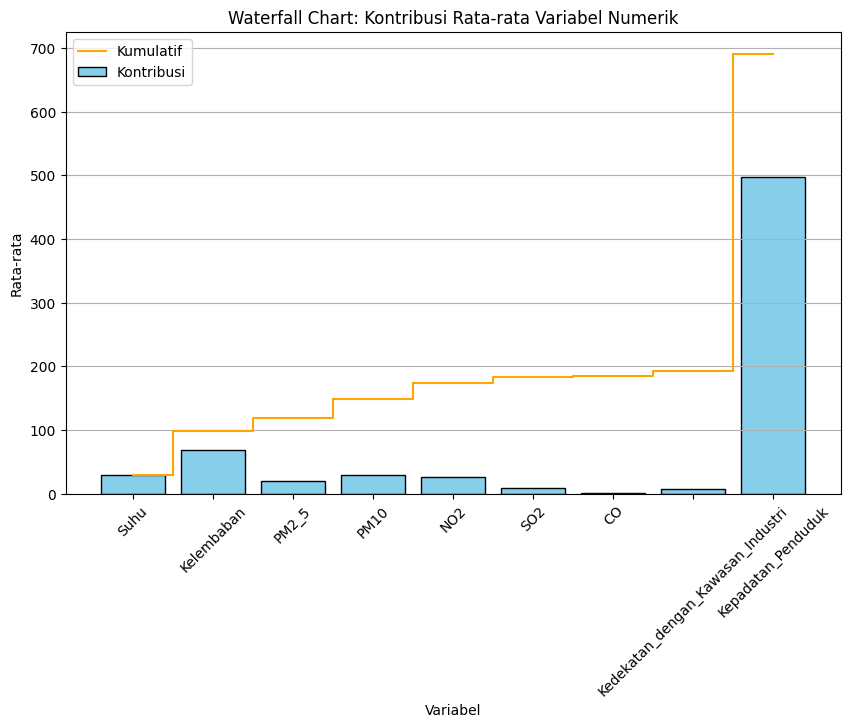

In [ ]:
# Waterfall
means = df.select_dtypes(include=['number']).mean()

# Menyiapkan data untuk waterfall chart
cumulative = means.cumsum()
positions = range(len(means))

# Membuat waterfall chart
plt.figure(figsize=(10, 6))
plt.bar(positions, means, color='skyblue', edgecolor='black', label='Kontribusi')
plt.step(range(len(cumulative)), cumulative, color='orange', label='Kumulatif', where='mid')
plt.title('Waterfall Chart: Kontribusi Rata-rata Variabel Numerik')
plt.xlabel('Variabel')
plt.ylabel('Rata-rata')
plt.xticks(positions, means.index, rotation=45)
plt.legend()
plt.grid(axis='y')
plt.show()


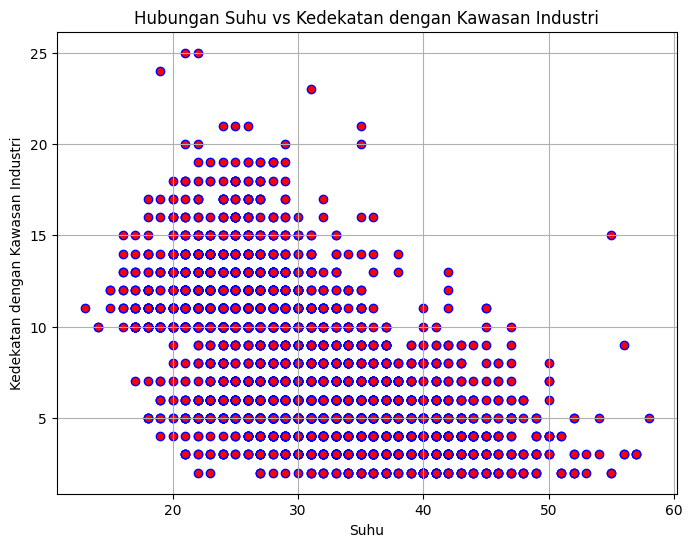

In [ ]:
# Scatter plot untuk Suhu vs Kedekatan_dengan_Kawasan_Industri
plt.figure(figsize=(8, 6))
plt.scatter(df['Suhu'], df['Kedekatan_dengan_Kawasan_Industri'], color='red', edgecolor='blue')
plt.title('Hubungan Suhu vs Kedekatan dengan Kawasan Industri')
plt.xlabel('Suhu')
plt.ylabel('Kedekatan dengan Kawasan Industri')
plt.grid(True)
plt.show()


Random Forest

In [ ]:
#Inisialisasi Spark
spark = SparkSession.builder.appName("PollutionDataAnalysis").getOrCreate()

# load data ke dalam Spark DataFrame
spark_df = spark.createDataFrame(df)
feature_columns = ['Suhu', 'Kelembaban', 'PM2_5', 'PM10', 'NO2', 'SO2', 'CO', 'Kedekatan_dengan_Kawasan_Industri', 'Kepadatan_Penduduk']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
spark_df = assembler.transform(spark_df)

# Ubah 'Air Quality' menjadi label numerik: Good -> 0, Moderate -> 1, Poor -> 2, Hazardous -> 3
spark_df = spark_df.withColumn(
    "label",
    F.when(spark_df["Air Quality"] == "Good", 0)
     .when(spark_df["Air Quality"] == "Moderate", 1)
     .when(spark_df["Air Quality"] == "Poor", 2)
     .when(spark_df["Air Quality"] == "Hazardous", 3)
     .otherwise(-1)
)
# Split data
train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=1234)
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
model = rf.fit(train_df)
predictions = model.transform(test_df)

#Evaluasi model
# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
precision = precision_evaluator.evaluate(predictions)
# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
recall = recall_evaluator.evaluate(predictions)
# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
# AUC (ROC Curve)
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = binary_evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"AUC (ROC Curve): {auc}")


Accuracy: 0.9027921406411582
Precision: 0.9778325123152709
Recall: 0.9974874371859297
F1 Score: 0.8987724620806452
AUC (ROC Curve): 0.9914224019923873


Gradient boost tree

In [ ]:
X = df.drop(["Air Quality"], axis=1)
y = df[["Air Quality"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
gb_clas = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, random_state=0)
gb_clas = gb_clas.fit(X_train, y_train)
y_pred = gb_clas.predict(X_test)

#Evaluasi model
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
# Precision
precision = precision_score(y_test, y_pred, average='weighted')
# Recall
recall = recall_score(y_test, y_pred, average='weighted')
# F1 Score
f1 = metrics.f1_score(y_test, y_pred, average='weighted')
# AUC (ROC Curve)
y_test_bin = label_binarize(y_test, classes=df['Air Quality'].unique())
y_pred_bin = label_binarize(y_pred, classes=df['Air Quality'].unique())
auc = roc_auc_score(y_test_bin, y_pred_bin, average='weighted', multi_class='ovr')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.936
Precision: 0.9352086014017718
Recall: 0.936
F1 Score: 0.9354539062396061
AUC: 0.958456011673723


2 metode Naive Bayes dan Support Vector Machine (SVM)

Naive Bayes

In [ ]:
X = df.drop(["Air Quality"], axis=1)
y = df[["Air Quality"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = GaussianNB()
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

#Evaluasi model
# Accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
# Precision
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))
# Recall
print("Recall:", metrics.recall_score(y_test, y_pred, average='weighted'))
# F1 Score
print("F1 Score:", metrics.f1_score(y_test, y_pred, average='weighted'))
# AUC (ROC Curve)
y_test_bin = label_binarize(y_test, classes=df['Air Quality'].unique())
y_pred_bin = label_binarize(y_pred, classes=df['Air Quality'].unique())
auc = roc_auc_score(y_test_bin, y_pred_bin, average='weighted', multi_class='ovr')
print("AUC:", auc)

Accuracy: 0.898
Precision: 0.8976234834644498
Recall: 0.898
F1 Score: 0.8974552243393401
AUC: 0.9339487660956612


 Support Vector Machine (SVM)

In [ ]:
# Inisialisasi StandardScaler and LabelEncoder
scaler = StandardScaler()
encoder = LabelEncoder()

scaler.fit(X)
X = scaler.transform(X)
y_encoded = encoder.fit_transform(y.values.ravel())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=0)

# Inisialisasi dan train model SVM
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

# prediksi
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)

#Evaluasi model
# Accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
# Precision
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))
# Recall
print("Recall:", metrics.recall_score(y_test, y_pred, average='weighted'))
# F1 Score
print("F1 Score:", metrics.f1_score(y_test, y_pred, average='weighted'))
# AUC (ROC Curve)
auc = metrics.roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')
print("AUC:", auc)

Accuracy: 0.933
Precision: 0.9321551559401561
Recall: 0.933
F1 Score: 0.9322052321779807
AUC: 0.9914062105273246


HYPERPARAMETER TUNING

In [ ]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model_gbt = grid_search.best_estimator_

# prediksi
y_pred_gbt = best_model_gbt.predict(X_test)

#Evaluasi model
# Accuracy
accuracy_gbt = accuracy_score(y_test, y_pred_gbt)
# Precision
precision_gbt = precision_score(y_test, y_pred_gbt, average='weighted')
# Recall
recall_gbt = recall_score(y_test, y_pred_gbt, average='weighted')
# F1 Score
f1_gbt = metrics.f1_score(y_test, y_pred_gbt, average='weighted')
# AUC (ROC Curve)
roc_auc_gbt = roc_auc_score(y_test, best_model_gbt.predict_proba(X_test), multi_class='ovr', average='weighted')

print("Gradient Boost Tree - Hyperparameter Tuning Results:")
print(f"Accuracy: {accuracy_gbt}")
print(f"Precision: {precision_gbt}")
print(f"Recall: {recall_gbt}")
print(f"F1-Score: {f1_gbt}")
print(f"ROC AUC: {roc_auc_gbt}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Gradient Boost Tree - Hyperparameter Tuning Results:
Accuracy: 0.932
Precision: 0.9317424010292729
Recall: 0.932
F1-Score: 0.9316650464526792
ROC AUC: 0.9940788877132825


In [ ]:
# Hyperparameter tuning SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(estimator=SVC(probability=True), param_grid=param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train, y_train)
best_model_svm = grid_search_svm.best_estimator_

# prediksi
y_pred_svm = best_model_svm.predict(X_test)

#Evaluasi model
# Accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
# Precision
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
# Recall
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
# F1 Score
f1_svm = metrics.f1_score(y_test, y_pred_svm, average='weighted')
# AUC (ROC Curve)
roc_auc_svm = roc_auc_score(y_test, best_model_svm.predict_proba(X_test), multi_class='ovr', average='weighted')

print("SVM - Hyperparameter Tuning Results:")
print(f"Accuracy: {accuracy_svm}")
print(f"Precision: {precision_svm}")
print(f"Recall: {recall_svm}")
print(f"F1-Score: {f1_svm}")
print(f"ROC AUC: {roc_auc_svm}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM - Hyperparameter Tuning Results:
Accuracy: 0.934
Precision: 0.932939882824526
Recall: 0.934
F1-Score: 0.9332289702506539
ROC AUC: 0.99285680004797
